Lidar Rays (287,)
Encoder Type (3,)
Gyro Type (4,)
Camera Image (560, 1280, 3)
Starting Timestamp (Lidar) 1544582648750747648.000000


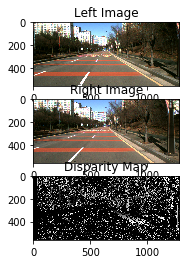

In [1]:
%load_ext autoreload
%autoreload 2
from Environment import Env
import numpy as np
import matplotlib.pyplot as plt
import math, cv2
import itertools

env = Env("env.pickle")

print("Lidar Rays", env.lidar_[0].shape)
print("Encoder Type", env.encoder_[0].shape)
print("Gyro Type", env.fog_[0].shape)
print("Camera Image", env.cameral_[0][1].shape)
np.set_printoptions(suppress=True)
print(f"Starting Timestamp (Lidar) {env.lidar_[0][0]:f}")

# Simple test for Stereo Camera
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=9) 
image_l_gray = cv2.cvtColor(env.cameral_[0][1], cv2.COLOR_BGR2GRAY)
image_r_gray = cv2.cvtColor(env.camerar_[0][1], cv2.COLOR_BGR2GRAY)
disparity = stereo.compute(image_l_gray, image_r_gray)
# Plot Figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(env.cameral_[0][1])
ax1.set_title('Left Image')
ax2.imshow(env.camerar_[0][1])
ax2.set_title('Right Image')
ax3.imshow(disparity, cmap='gray')  
ax3.set_title('Disparity Map')
plt.show()

In [2]:
# Simple test of Encoder
from sensors.Encoder import Encoder
enc = Encoder()
enc.Init(env.encoder_[0][0], env.encoder_[0][1], env.encoder_[0][2])
v1l, v1r = enc.Update(env.encoder_[1][0], env.encoder_[1][1], env.encoder_[1][2])
v2l, v2r = enc.Update(env.encoder_[2][0], env.encoder_[2][1], env.encoder_[2][2])
v1l, v1r, v2l, v2r

(4.638232548313141, 4.6332259153631705, 4.591331685442802, 4.586375678545532)

In [3]:
# Simple test of FOG
from sensors.FOG import FOG
fog = FOG()
fog.Init(env.fog_[0][0])
wr, wp, wy = fog.Update(env.fog_[1][0], env.fog_[1][1], env.fog_[1][2], env.fog_[1][3])
wr, wp, wy

(-0.007482616228902051, 0.02508183088586922, -0.011244718317272343)

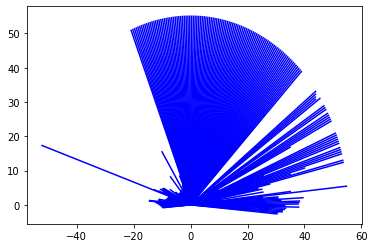

In [4]:
# Simple test of Lidar Sensor
from sensors.Lidar import Lidar
lidar = Lidar()
test_lidar, obs = lidar.Detect(env.lidar_[0][1:])

for ex, ey, _ in test_lidar:
    plt.plot([0, ex], [0, ey], color="blue")
plt.show()

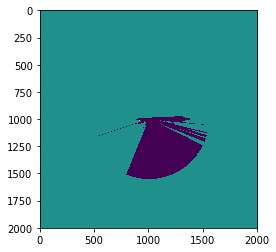

<Figure size 432x288 with 0 Axes>

In [5]:
# Simple test for O-Map
from OccupancyMap import OccupancyMap
np.set_printoptions(threshold=np.inf)

omap = OccupancyMap()
omap.Update(test_lidar, obs, True)

Starting Timestamp 154458264875.000000


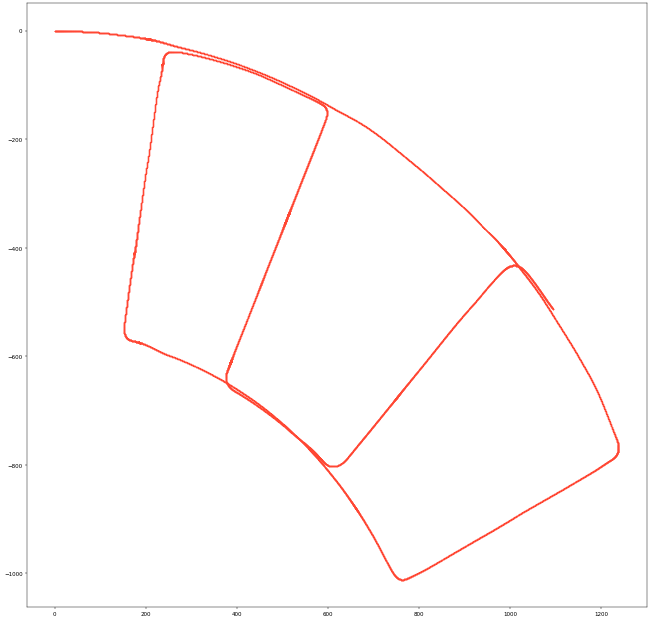

In [6]:
# Simple test for Dead-Reckoning
from Robot import Robot
st = 154458264875
enc_cur = 0
lidar_cur = 0
fog_cur = 0

cur_t = env.encoder_[enc_cur][0] // 1e7
while env.fog_[fog_cur][0] // 1e7 != st:
    fog_cur += 1

robot = Robot(None, np.log(9), 1, np.zeros((3, 3)))
robot.Init(env.fog_[fog_cur], env.encoder_[enc_cur], env.lidar_[lidar_cur][1:])
print(f"Starting Timestamp {cur_t:f}")

# Starting Place
enc_cur += 1
st = env.encoder_[enc_cur][0] // 1e7

states = []
while enc_cur < len(env.encoder_):
#     print(f"Processing Timestamp {st:f}")
    cur_enc = env.encoder_[enc_cur]
    
    # For FOG, get all
    cur_fog = np.zeros(3)
    while env.fog_[fog_cur][0] // 1e7 != st:
        cur_fog += env.fog_[fog_cur][1:]
        fog_cur += 1
    cur_fog += env.fog_[fog_cur][1:]

    robot.Predict(np.hstack((env.fog_[fog_cur][0], cur_fog)), cur_enc)

    # For next iter
    fog_cur += 1
    enc_cur += 1
    if enc_cur < len(env.encoder_):
        st = env.encoder_[enc_cur][0] // 1e7

    states.append(np.copy(robot.State))

fig, ax = plt.subplots(figsize=(20, 20), dpi=40)
for x, y, _ in states:
    ax.plot(x, y, marker='o', color='#ff4733', ms=1)
plt.show()

Starting Timestamp 154458264875.000000
Start Painting


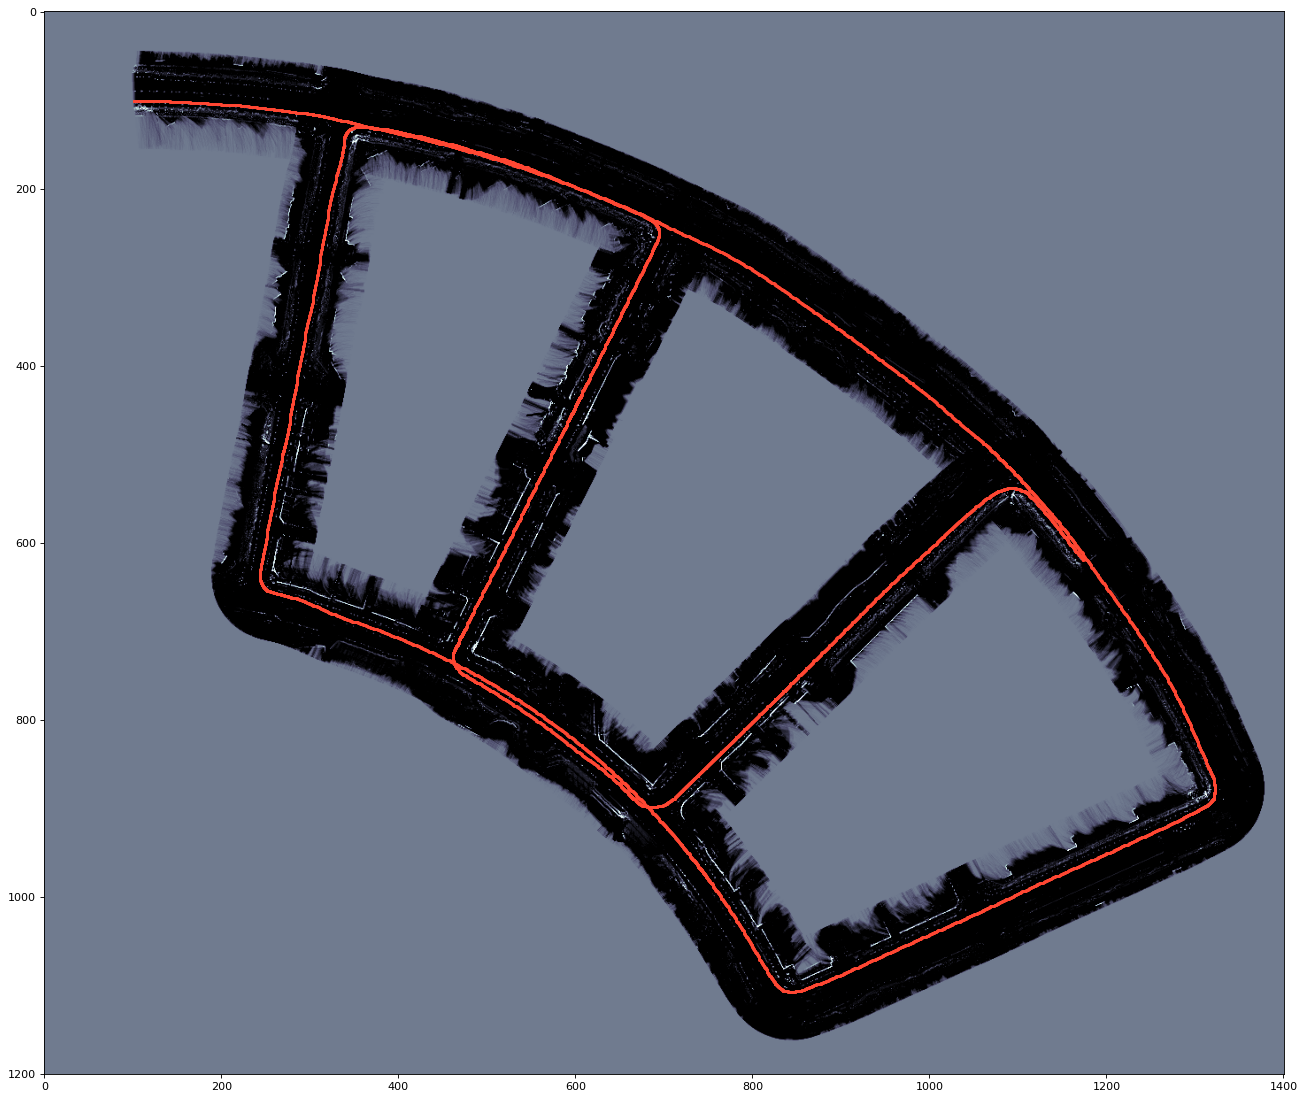

In [12]:
# Full particle SLAM
st = 154458264875
enc_cur = 0
lidar_cur = 0
fog_cur = 0

cur_t = env.encoder_[enc_cur][0] // 1e7
while env.fog_[fog_cur][0] // 1e7 != st:
    fog_cur += 1

map_config = {
    "xmin" : -100,
    "xmax" : 1300,
    "ymin" : -1100,
    "ymax" : 100,
    "res" : 1,
    "trust" : 0.8,
    "logmin" : -100,
    "logmax" : 100
}    

robot = Robot(map_config, np.log(9), 25, np.diag([1e-7, 1e-7, 1e-7]), 4, 9)
robot.Init(env.fog_[fog_cur], env.encoder_[enc_cur], env.lidar_[lidar_cur][1:])
print(f"Starting Timestamp {cur_t:f}")

# Starting Place
enc_cur += 1
lidar_cur += 1

states = []
while lidar_cur < len(env.lidar_):
    st = env.lidar_[lidar_cur][0] // 1e7
    cur_enc = env.encoder_[enc_cur]
    cur_lidar = env.lidar_[lidar_cur]
    
    # For FOG, get all
    cur_fog = np.zeros(3)
    while env.fog_[fog_cur][0] // 1e7 != st:
        cur_fog += env.fog_[fog_cur][1:]
        fog_cur += 1
    cur_fog += env.fog_[fog_cur][1:]

    robot.Predict(np.hstack((env.fog_[fog_cur][0], cur_fog)), cur_enc)
    robot.Update(cur_lidar[1:])
    robot.UpdateOccupancyMap(cur_lidar[1:])

    # For next iter
    fog_cur += 1
    enc_cur += 1
    lidar_cur += 1

    states.append(np.copy(robot.State))

print("Start Painting")
map_ind = robot.omap_.GetCoordinates(np.array(states)).T
posx, posy = map_ind
fig2, ax2 = plt.subplots(figsize=(20, 20), dpi=80)
ax2.imshow(np.flip(robot.omap_.lambda_, 0), cmap='bone')
for x, y in zip(posx, posy):
    ax2.plot(x, robot.omap_.lambda_.shape[0] - y, marker='o', color='#ff4733', ms=1)
plt.savefig("p25_l55_9_1e-7.png")

Starting Timestamp 154458264875.000000
Start Painting


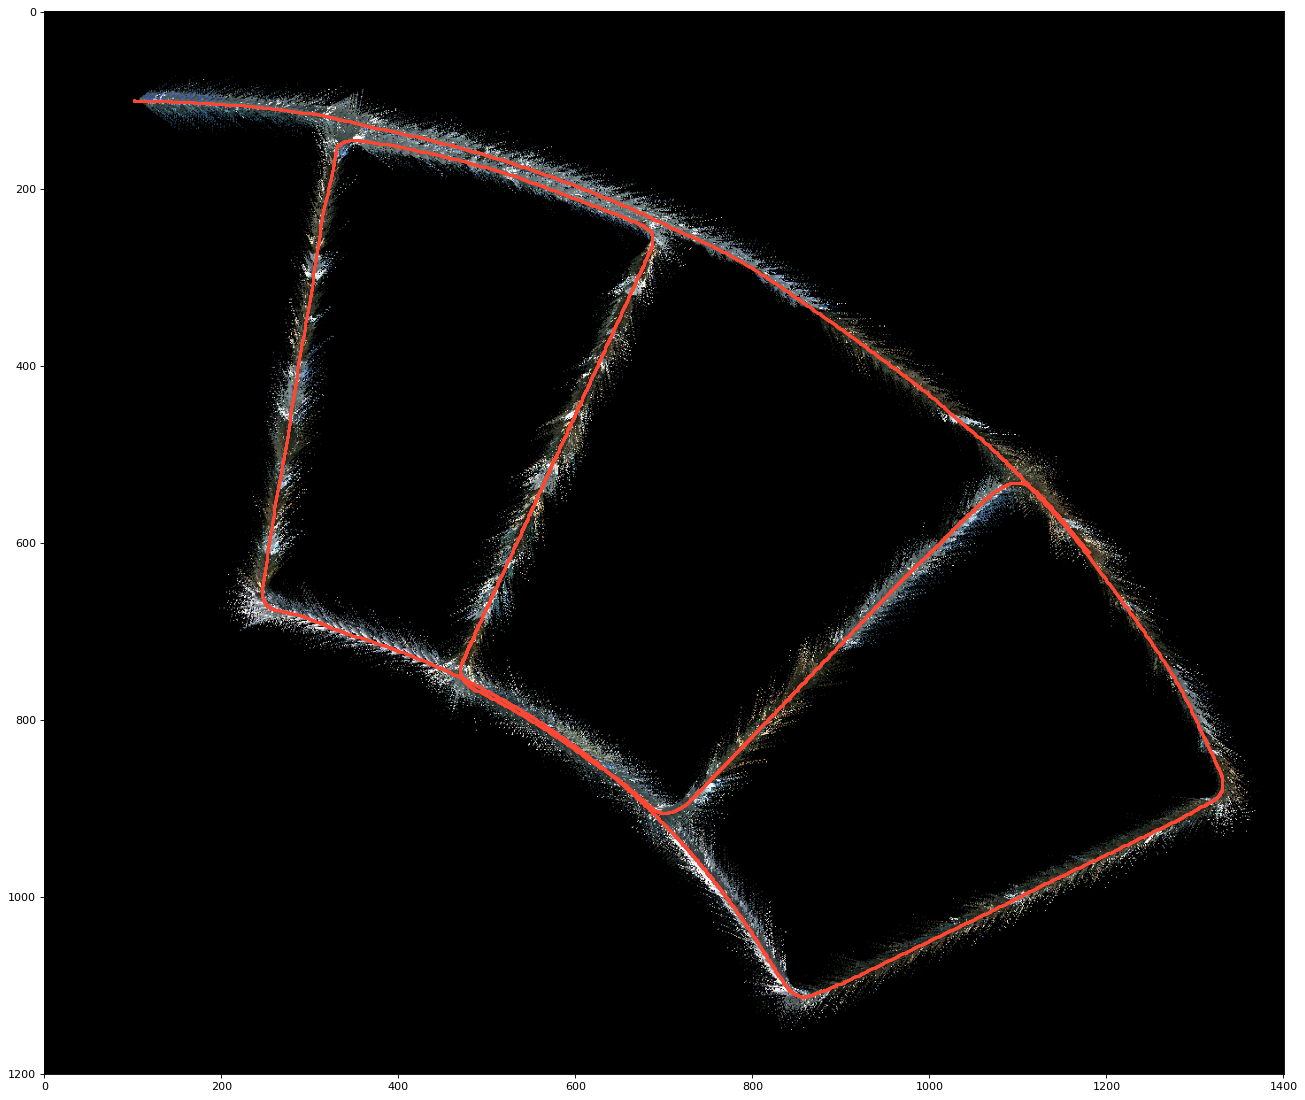

In [25]:
# Simple test for full particle SLAM with texture map
st = 154458264875
enc_cur = 0
lidar_cur = 0
fog_cur = 0

cur_t = env.encoder_[enc_cur][0] // 1e7
while env.fog_[fog_cur][0] // 1e7 != st:
    fog_cur += 1

map_config = {
    "xmin" : -100,
    "xmax" : 1300,
    "ymin" : -1100,
    "ymax" : 100,
    "res" : 1,
    "trust" : 0.8,
    "logmin" : -100,
    "logmax" : 100
}    

robot = Robot(map_config, np.log(9), 50, np.diag([1e-7, 1e-7, 1e-7]), 4, 9)
robot.Init(env.fog_[fog_cur], env.encoder_[enc_cur], env.lidar_[lidar_cur][1:])
print(f"Starting Timestamp {cur_t:f}")

# Starting Place
enc_cur += 1
lidar_cur += 1
camera_cur = 1

states = []
while lidar_cur < len(env.lidar_):
    st = env.lidar_[lidar_cur][0] // 1e7
    cur_enc = env.encoder_[enc_cur]
    cur_lidar = env.lidar_[lidar_cur]
    
    # For FOG, get all
    cur_fog = np.zeros(3)
    while env.fog_[fog_cur][0] // 1e7 != st:
        cur_fog += env.fog_[fog_cur][1:]
        fog_cur += 1
    cur_fog += env.fog_[fog_cur][1:]

    robot.Predict(np.hstack((env.fog_[fog_cur][0], cur_fog)), cur_enc)
    robot.Update(cur_lidar[1:])
    robot.UpdateOccupancyMap(cur_lidar[1:])
    
    if camera_cur % 100 == 0:
        robot.UpdateTextureMap(env.cameral_[camera_cur // 100][1], \
                               env.camerar_[camera_cur // 100][1])

    # For next iter
    fog_cur += 1
    enc_cur += 1
    lidar_cur += 1
    camera_cur += 1

    states.append(np.copy(robot.State))

print("Start Painting")
map_ind = robot.omap_.GetCoordinates(np.array(states)).T
posx, posy = map_ind
fig2, ax2 = plt.subplots(figsize=(20, 20), dpi=80)
ax2.imshow(np.flip(robot.map_texture_, 0), cmap=None)
for x, y in zip(posx, posy):
    ax2.plot(x, robot.omap_.lambda_.shape[0] - y, marker='o', color='#ff4733', ms=1)
plt.savefig("colored_p50_l55_9_1e-7.png")